This notebook contains the ML model that predicts log of the sales. It could just as well predict the sales themselves, but given the range of values for sales, it makes more sense to predict the log. An error of \\$50,000 on a 1.5 million dollars game would be less substantial than the same error on a \\$100,000 game.

The notebook assumes that the data set is already cleaned and ready to be used. See the data engineering notebook for the data preparation.

There are three kinds of columns in the data set: numerical (e.g. sales), categorical (e.g. platform, genre), and free-form text (e.g. summary). The numerical data does not require any further preparation. The categorical data will be one-hot encoded. Some categorical columns contain singular values and will be transformed using OneHotEncoder. Other categorical columns contain lists that will use DictVectorizer. Note that the majority of the categorical columns contain numerical values, but these simply represent different classes of whatever data the columns hold. The free-form text will be transformed using TF-IDF vectorizer.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

from tdi_capstone_common_functions import *
# the two functions imported are: standardize_string and pseudo_list_parser

The data, loaded into a pandas data frame, has a lot of columns. While the data engineering notebook dropped columns that were not useful for predictions, specifically a lot of meta-data (e.g., the url for the game on IGDB), there are still columns that may be useful, but may as well not be. They were retained up to this point, but are now dropped. They may be used in future versions of the model. Some, however, can and shouled be dropped regardless, such asname, release_year, closest_match, match_score, id, first_release_date, and release_dates.

In [2]:
# load the data
drop_columns = [
    'name',
    'release_year',
    'closest_match',
    'match_score',
    'id',
    'first_release_date',
    'release_dates',
    'alternative_names',
    'external_games',
    'similar_games',
    'language_supports',
    'status',
    'bundles',
    'collections',
    'parent_game',
    'collection'
    ]

df = (pd.read_csv('data_complete.csv', index_col='index')
      .drop(drop_columns, axis=1))

Since different kinds of columns will be transformed using different transformers, it is easy to create lists of columns according to their kind.

In [3]:
# columns with numerical data
numeric_columns = ['sales_na', 'sales_eu', 'sales_jp', 'sales_other', 'sales_global']

# columns with free-form text
text_columns = ['summary', 'storyline']

# columns that contain lists (imported as strings that look like lists)
list_columns = ['age_ratings', 'game_modes', 'genres', 'themes', 'involved_companies', 'keywords',
               'multiplayer_modes', 'franchises', 'game_engines', 'player_perspectives', 'game_localizations']

# parse the columns that contain pseudo-lists into lists and populate those with a non-list (NaN) with an empty list
df[list_columns] = df[list_columns].applymap(lambda x: pseudo_list_parser(x)).applymap(lambda x: x if isinstance(x, list) else [])

# since most columns won't use OneHotEncoder, it is easier to exclude columns from df.columns than to explicitly list them out
non_ohe_columns = numeric_columns + text_columns + list_columns
# creates a list with the columns that do not appear in any of the above lists
ohe_columns = [column_name for column_name in df.columns if column_name not in non_ohe_columns]

## Building the model

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer

from sklearn.decomposition import TruncatedSVD # used for dimensionality reduction

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

As mentioned above, there are three kinds of columns: numerical, categorical, and free-form text. Numerical data does not require any transformation at this point. The categorical columns can be divided into two subtypes, columns with singular values that will be transformed using OneHotEncoder and columns with lists of values that will be transformed with DictVectorizer. Lastly, free-form text will use TfidfVectorizer. Each of these kinds of transformations will be stored as a list of transformers with their relevant columns, so they can all eventually be put together into a single list of transformers passed onto the ColumnTransformer of the model.

First to be treated are the OneHotEncoder categorical columns. It is created as a tuple (per usual format of transformers) and then places into a list, so that it can easily be added to the other transformers.

In [5]:
ohe_transformers = [('categorical', OneHotEncoder(handle_unknown='ignore'), ohe_columns)]
#ohe_transformer = ('categorical', OneHotEncoder(handle_unknown='ignore'), ohe_columns)

Then the categorical columns with lists of values. Each one of these lists is first encoded as a dictionary (using a custom class) and then vectorized.

In [6]:
class DictEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
#         X_trans = pd.DataFrame()
        
#         for column in X.columns:
#             column_trans = [{key: 1 for key in item} for item in X[column]]
#             X_trans[column] = column_trans
        
#         return X_trans
        return [{key: 1 for key in row} for row in X] #, name=X.name)

Because the transformer first needs to encode and then vectorize the list, a pipeline is used.

In [7]:
list_column_vectorizer = Pipeline([
    ('dict_encoder', DictEncoder()),
    ('dict_vectorizer', DictVectorizer())
])

Then a list is created, where every element is the tuple format of a transformer (name, transformer, column(s)) for every column. This way, it is possible to access specific transformers by its name via the named_steps method.

In [8]:
list_column_transformers = [(f'list_vect_{column}', list_column_vectorizer, f'{column}') for column in list_columns]
#list_column_transformer = ('list_columns', list_column_vectorizer, list_columns)

Lastly, the free-form text columns are treated, where the strings are first standardized and then vectorized using TF-IDF. Very rare words are excluded, represented by the min_df value. Additionally, a relatively low max_df is set to exclude words that appear in a lot of game descriptions, since we want to use the most impactful words.

In [9]:
def text_column_preprocessing(series):
    """
    Standardizes a series containing free-form strings.
    
    Parameter
    ---------
    series : pandas.Series()
        A series of strings to be standardized, retaining only alphanumeric characters,
        changing East Asian characters into Latin ones, and removing symbols and parentheses.
    
    Returns
    -------
    pandas.Series
        A series of standardized strings.
    """
    
    return series.map(standardize_string)

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from spacy.lang.en.stop_words import STOP_WORDS

STOP_WORDS = STOP_WORDS.difference({'he','his','her','hers'}).union({'ll', 've'})

text_column_vectorizer = Pipeline([
    ('standardize_text', FunctionTransformer(text_column_preprocessing)),
    ('tfidf', TfidfVectorizer(min_df=20, max_df=0.5, stop_words=list(STOP_WORDS)))
])

Much like in the case with the list columns, a list of tuples is created, each referring to an individual free-form text column.

In [11]:
text_column_transformers = [(f'text_{column}', text_column_vectorizer, f'{column}') for column in text_columns]
#text_column_transformer = ('text_columns', text_column_vectorizer, text_columns)

It is now possible to build the model. All the features will undergo their respective transformations (remember that the numerical columns do not need any at this point).

In [12]:
features = ColumnTransformer(
    transformers = list_column_transformers + ohe_transformers + text_column_transformers,
    remainder='drop')

The model was trained with several regressors alongside appropriate parameter grids. These include LinearRegression, Ridge, RandomForestRegressor, and KNeighborsRegressor. Out of all of them, Ridge seemed to performed the best. In order to streamline building different versions of the model, a function allows for a quick customization of the regressor.

Note that the data set ends up having quite a lot of features, particularly due to the free-form text vectorizer. Given the number of observations, this needs to be taken into account. To balance that, some kind of dimensionality reduction can help to improve the model. Post-transformation, the data is stored in a sparse matrix, and since PCA doesn't work with sparse data, we'll use TruncatedSVD.

In [13]:
def generate_regressor(requested_model='ridge', hyperparameters=None, requested_dr='default', cv=5, n_jobs=2):
    """
    Creates a regressor with grid search cross-validation.
    
    Parameters
    ----------
    requested_model : string or sklearn model, default 'ridge'
        The name of the model as a string or an instantiated model
        object itself. Currently supported models: LinearRegression, Ridge,
        RandomForestRegressor, KNeighborsRegressor. Defaults to Ridge
        if anything else is given.
    hyperparameters : dict, default None
        The hyperparameters for grid search cross-validation based on
        the regressor. If not passed, defaults to the built-in ones.
    requested_dr : string or list, default 'default'
        Indicates how dimensionality reduction using TruncatedSVD should
        work. Accepted strings are 'default' for the default values based
        on the model chosen, 'aggressive' to reduce to hundreds of features,
        or 'relaxed' to reduce to tens of features. Alternatively, a list
        can be passed with the possible values.
    cv : int, default 5
        The number of folds in the cross validation.
    n_jobs : int, default 2
        The number of parallel jobs for the cross validation.
    
    Returns
    -------
    GridSearchCV object
        An object based on the requested model or the default if that
        type of regressor is not supported by the function. The parameter
        grid is also set for the specified model.
    
    Notes
    -----
    The currently supported models are linear regression, ridge, random
    forest, and k-nearest neighbors. All but the last one use a relaxed
    dimensionality reduction (n_components = [100, 250, 500]) by default,
    with k-nearest neighbors using an aggressive one
    (n_components = [10, 20, 30]). The built-in default hyperparameters
    for each are as follows:
        Ridge :
            'alpha': [0.1, 1.0, 10.0]
        Random Forest :
            'n_estimators': [10, 50, 100, 200, 300],
            'max_depth': [None, 10, 20, 50],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        K-Nearest Neighbors :
            'n_neighbors': [3, 5, 8, 10, 15]  
    """

    #
    if isinstance(requested_model, str):
        supported_models = {
            'linearregression': LinearRegression(),
            'lr': LinearRegression(),
            'linear': LinearRegression(),
            'ridge': Ridge(),
            'randomforestregressor': RandomForestRegressor(),
            'randomforest': RandomForestRegressor(),
            'kneighborsregressor': KNeighborsRegressor(),
            'knn': KNeighborsRegressor()
        }
        
        model = supported_models.get(requested_model.lower(), Ridge())
        
    # The default values for dimensionality reduction
    dr_values = {
        'relaxed': [100, 250, 500],
        'aggressive': [10, 20, 30] # for, e.g., KNN
    }
    
    # if the function was passed a specific list of dimensionality reduction values, it will use that list
    if isinstance(requested_dr, list):
        dr = requested_dr
    else:
        # if a string was passed, it will use one of the two built-in options, either aggressive or relaxed dimensionality
        # reduction; or if the string was 'default' or another non-supported string, it will use a default set of values.
        # These are based on the model requested, and so a function is used to determine which of the two built-in options
        # to use.
        def find_default_dr(model_for_dr):
            aggressive_dr_models = [KNeighborsRegressor] # list of models which default to aggressive dimensionality reduction
            
            if model_for_dr in aggressive_dr_models:
                return dr_values['aggressive']
            
            return dr_values['relaxed']
        
        # find the correct built-in value for dimensionality reduction
        dr = dr_values.get(requested_dr, find_default_dr(model))

    # Initiliazes the dimensionality reduction object
    svd = TruncatedSVD()
    
    # Initializes the parameter grid with the dimensionality reduction values
    param_grid = {'dim_reduction__n_components': dr}
    
    # If no parameter grid was passed, use the built-in values
    if not hyperparameters:
        
        if isinstance(model, Ridge):
            hyperparameters = {
                'alpha': [0.1, 1.0, 10.0]
            }
        elif isinstance(model, RandomForestRegressor):
            hyperparameters = {
                'n_estimators': [10, 50, 100, 200, 300],
                'max_depth': [None, 10, 20, 50],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }
        elif isinstance(model, KNeighborsRegressor):
            hyperparameters = {
                'n_neighbors': [3, 5, 8, 10, 15]   
            }
        else: # default if model does not have hyperparameters, e.g. linear regression
            hyperparameters = {}
    
    # renames the keys so they can be properly accessed
    hyperparameters = {f'regressor__{k}' : v for k, v in hyperparameters.items()}
        
    # Updates the parameter grid (currently only with dimensionality reduction) with the regressor's hyperparameters.
    param_grid.update(hyperparameters)
        
    estimator = Pipeline([
        ('dim_reduction', svd),
        ('regressor', model)
    ])

    gs = GridSearchCV(
        estimator,
        param_grid=param_grid,
        cv=cv,
        n_jobs=n_jobs
    )

    return gs

It is then possible to build the model with different kinds of regression algorithms or parameter grids. 

In [ ]:
model = Pipeline([
    ('features', features),
    ('main_regressor', generate_regressor('ridge'))
])

## Training the model

As mentioned above, the numerical columns are only the sales, which are also the (basis of the) labels, so these can be dropped from the feature matrix passed onto the model. The labels are going to be the log of the global sales. In the future, it would be possible to have the model predict localized sales (e.g. EU, US, etc).

In [ ]:
X = df.drop(numeric_columns, axis=1)
y = np.log(df['sales_global'])

The data is then split into a training set and a test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

The model is then fit with the training set.

In [ ]:
model.fit(X_train, y_train)

## Saving and loading the trained model
The model can then be serialized and saved into a file so it doesn't have to be trained again. A container (list) object is created that will hold the model itself, as well as the train/test split of the data that was used in its training.

In [15]:
import pickle

In [ ]:
data_container = [model, X_train, X_test, y_train, y_test]

with open('model.pickle', 'wb') as f:
    pickle.dump(data_container, f)

If the model has already been pickled, it can be imported.

In [ ]:
with open('model', 'rb') as f:
    loaded_container = pickle.load(f)

model, X_train, X_test, y_train, y_test = loaded_container

## Making predictions
Predictions can then be made:

In [ ]:
y_pred = model.predict(X_test)

## Assessing model performance
It's then possible to observe some metrics on the performance of the model.

In [59]:
from sklearn import metrics

In [ ]:
y_pred = pipe.predict(X_test)

In [ ]:
print(f"Mean absolute error: {metrics.mean_absolute_error(y_test, y_pred)}")
print(f"Mean squared error: {metrics.mean_squared_error(y_test, y_pred)}")
print(f"R^2: {metrics.r2_score(y_test, y_pred)}")

In [ ]:
pipe.score(X_test, y_test)

## Working with multiple models

So far only one model was used. But we can train multiple models to see the differences in performances and predictive power. To be consistent, the same train/test data split will be used. The trained models are then saved as a dictionary.

In [ ]:
algorithms = ['lr', 'ridge', 'knn', 'randomforest']
# Note that these need to be strings accepted by the generate_regressor function. Note also that depending on the model requested
# this might take a while to run (e.g., with this data set, the random forest regressor will take hours and hours to train).

models = dict()

for algorithm in algorithms:
    model = Pipeline([
        ('features', features),
        ('main_regressor', generate_regressor(algorithm, cv=10, n_jobs=-1))
    ])
    model.fit(X_train, y_train)
    models[algorithm] = model

Once we trained several models and saved them as a dictionary, we can then save them into different files.

In [ ]:
for model_name, model in models.items():
    with open(f'{model_name}.pickle', 'wb') as f:
        data_container = [model, X_train, X_test, y_train, y_test]
        pickle.dump(data_container, f)

Similarly, we can load the pickled models. This time, we are going to use an embedded dictionary. The top level's keys are the name of the model, and the values are embedded dictionaries that contain the trained model object itself ('model') as well as the train/test data split. This is done in order to retain the associated train/test split data used for the training of each model. Note, however, that in this case, all of models would have the same train/test split data, because that's how they were saved above.

In [47]:
algorithms = ['lr', 'ridge', 'knn', 'randomforest']

loaded_models = dict()

for algorithm in algorithms:
    with open(f'{algorithm}.pickle', 'rb') as f:
        # The embedded dict is reset every loop as otherwise all loaded models would actually point to the last dict (here: randomforest)
        trained_model = dict()
        trained_model['model'], trained_model['X_train'], trained_model['X_test'], trained_model['y_train'], trained_model['y_test'] = pickle.load(f)
        loaded_models[algorithm] = trained_model

We can run predictions to each of them and save them to their corresponding model in the loaded_models dictionary.

In [51]:
for model in loaded_models.values():
    model['y_pred'] = model['model'].predict(model['X_test'])

In [54]:
for model_name, model in loaded_models.items():
    print(f'For {model_name}:')
    print(f"Mean absolute error: {metrics.mean_absolute_error(model['y_test'], model['y_pred'])}")
    print(f"Mean squared error: {metrics.mean_squared_error(model['y_test'], model['y_pred'])}")
    print(f"R^2: {metrics.r2_score(model['y_test'], model['y_pred'])}")
    print('')

For lr:
Mean absolute error: 0.8173556466817667
Mean squared error: 1.149279655508038
R^2: 0.5197002033564457

For ridge:
Mean absolute error: 0.8106476823277217
Mean squared error: 1.171809867623642
R^2: 0.5102845174129952

For knn:
Mean absolute error: 0.8923915907997727
Mean squared error: 1.316066308424797
R^2: 0.44999776401119607

For randomforest:
Mean absolute error: 0.8933907637672172
Mean squared error: 1.2946976024871029
R^2: 0.45892804052589997



## Data visualization

In [61]:
import matplotlib.pyplot as plt

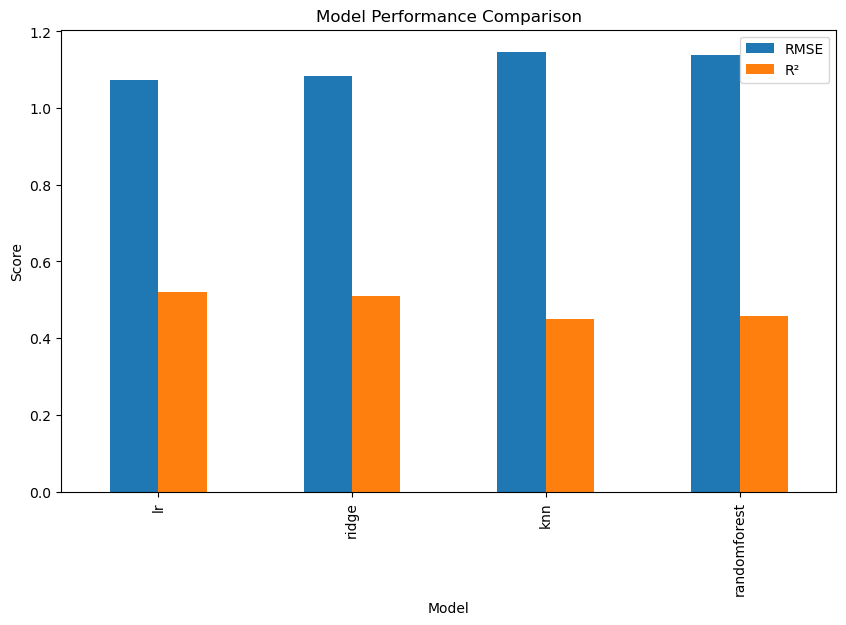

          Model      RMSE        R²
0            lr  1.072045  0.519700
1         ridge  1.082502  0.510285
2           knn  1.147199  0.449998
3  randomforest  1.137848  0.458928


In [62]:
metrics_list = []

for model_name, model in loaded_models.items():
    rmse = np.sqrt(metrics.mean_squared_error(model['y_test'], model['y_pred']))
    r2 = metrics.r2_score(model['y_test'], model['y_pred'])
    metrics_list.append({'Model': model_name, 'RMSE': rmse, 'R²': r2})

metrics_df = pd.DataFrame(metrics_list)

# Bar plot
metrics_df.set_index('Model')[['RMSE', 'R²']].plot(kind='bar', figsize=(10, 6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.show()

# Alternatively, print the table
print(metrics_df)

In [63]:
import seaborn as sns

def plot_predicted_vs_actual(actual_values, predicted_values, units='log of sales'):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual_values, y=predicted_values, alpha=0.5)
    sns.lineplot(x=[min(actual_values), max(actual_values)], y=[min(actual_values), max(actual_values)], color='red', linestyle='--')
    plt.xlabel(f'Actual values ({units})')
    plt.ylabel(f'Predicted values ({units})')
    plt.title(f'Actual vs predicted values ({units})')
    plt.show()

<class 'sklearn.linear_model._base.LinearRegression'>


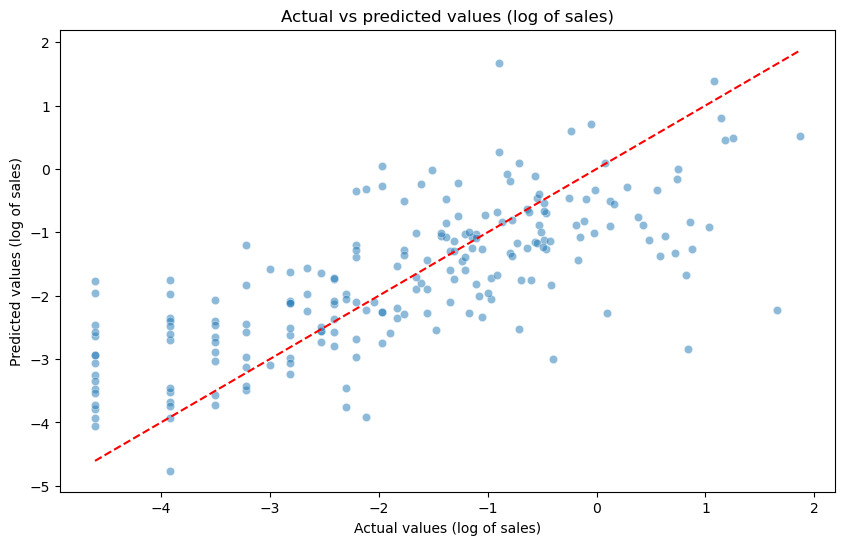

<class 'sklearn.linear_model._ridge.Ridge'>


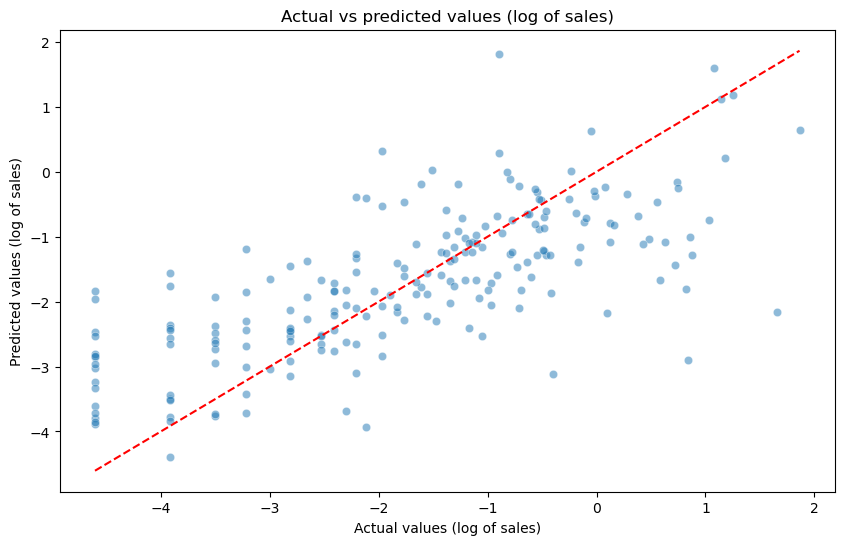

<class 'sklearn.neighbors._regression.KNeighborsRegressor'>


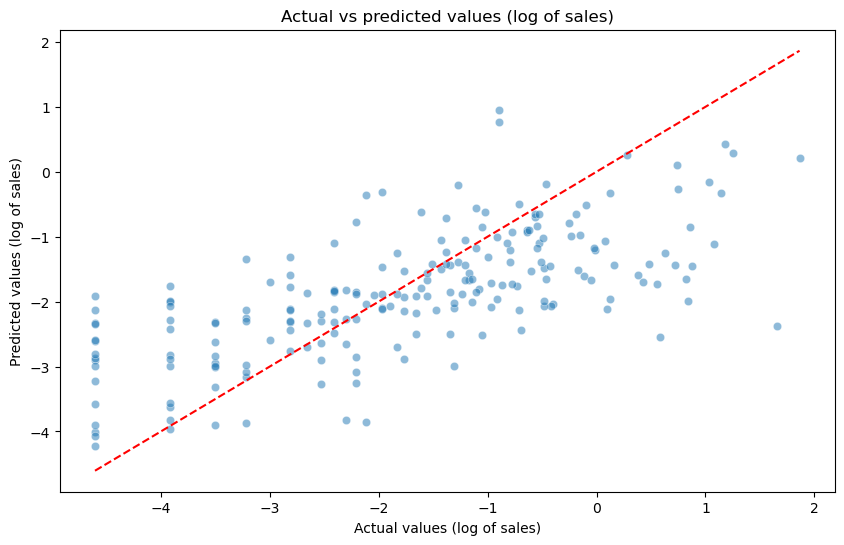

<class 'sklearn.ensemble._forest.RandomForestRegressor'>


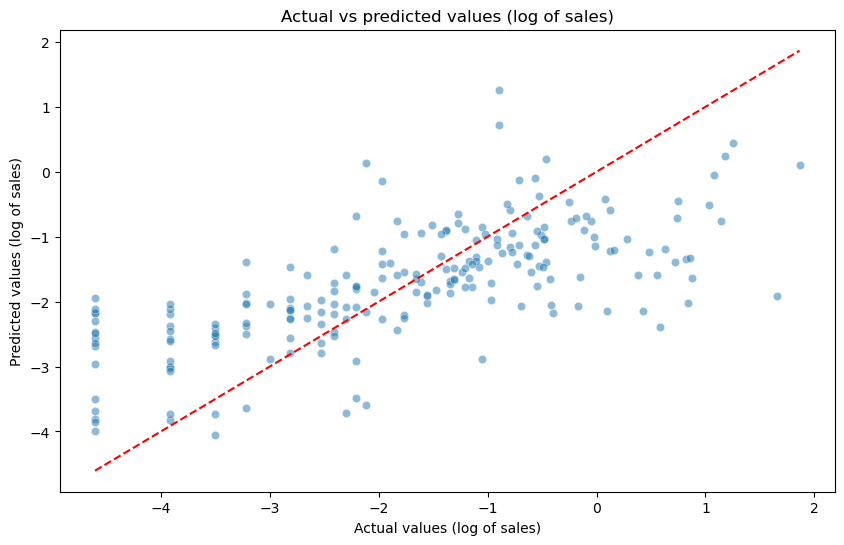

In [70]:
for model_name, model in loaded_models.items():
    print(type(model['model'].named_steps.main_regressor.estimator.named_steps.regressor))
    plot_predicted_vs_actual(model['y_test'], model['y_pred'])